
# NLP Tutorial #5 — Text Classification & Naive Bayes
**Goals**
- Understand what **text classification** is and common use-cases.
- Learn the **Naive Bayes** family (MultinomialNB & BernoulliNB) for text.
- Build **end-to-end pipelines** with scikit-learn: data → vectorization → train → evaluate.
- Compare **Bag-of-Words vs TF–IDF**, **n-grams**, and tune **alpha**.
- Do **error analysis** and **feature introspection** (top words per class).



## 0. Runtime & installs (Colab)
If you're on Colab, the following cell ensures the right packages are present.


In [ ]:

# If you're on local Jupyter with sklearn already installed, you can skip/disable this.
!pip -q install scikit-learn matplotlib==3.*



## 1. Imports & Utilities


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch

import textwrap
import itertools
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)



## 2. What is Text Classification?
Text classification assigns **labels** to raw text (emails → *spam/ham*, reviews → *positive/negative*, news → *topics*).
We convert text into **features** (vectors), then train a model to map vectors → labels.

- Bag-of-Words counts tokens. TF–IDF down-weights common words.
- We prefer **simple, scalable** models first. Naive Bayes is a classic baseline that often performs surprisingly well.



## 3. Dataset: 20 Newsgroups (subset for speed)
We'll use a compact subset (8 classes) to keep training fast on Colab.


In [ ]:

CATEGORIES = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
    'rec.autos', 'rec.sport.baseball', 'sci.med', 'talk.politics.mideast'
]

train = fetch_20newsgroups(subset='train', categories=CATEGORIES, remove=('headers','footers','quotes'))
test  = fetch_20newsgroups(subset='test',  categories=CATEGORIES, remove=('headers','footers','quotes'))

X_train, y_train = train.data, train.target
X_test,  y_test  = test.data,  test.target
target_names = train.target_names

len(X_train), len(X_test), target_names


(4692,
 3125,
 ['comp.graphics',
  'comp.os.ms-windows.misc',
  'comp.sys.ibm.pc.hardware',
  'comp.sys.mac.hardware',
  'rec.autos',
  'rec.sport.baseball',
  'sci.med',
  'talk.politics.mideast'])






### Peek at a few samples


In [ ]:

for i in range(3):
    print(f"--- Sample {i+1} (label={target_names[y_train[i]]}) ---")
    print(textwrap.fill(X_train[i].strip().replace("\n"," "), width=100))
    print()


--- Sample 1 (label=sci.med) ---
Okay Mr. Dyer, we're properly impressed with your philosophical skills and ability to insult people.
You're a wonderful speaker and an adept politician. However, I believe that all you were asked to
do, was simply provide scientific research refuting the work of Olney. I don't think the original
poster sought to start a philisophical debate. she wanted some information. Given a little effort
one could justify that shooting oneself with a .45 before breakfast is a healthy practice. But we're
not particularily interested in what you can verbally prove/disprove or rationalize. Where's the
research? Where are the studies?  I appoligize if this sounds flamish. I simply would like to see
the thread get back on track.    Lone Wolf

--- Sample 2 (label=talk.politics.mideast) ---
What gives the US the right to keep New York?  It is the home of the United Nations as well as being
home to a myriad of ethnic groups.  (Actually, NYC is more comparable to the Gaza St


### Class distribution


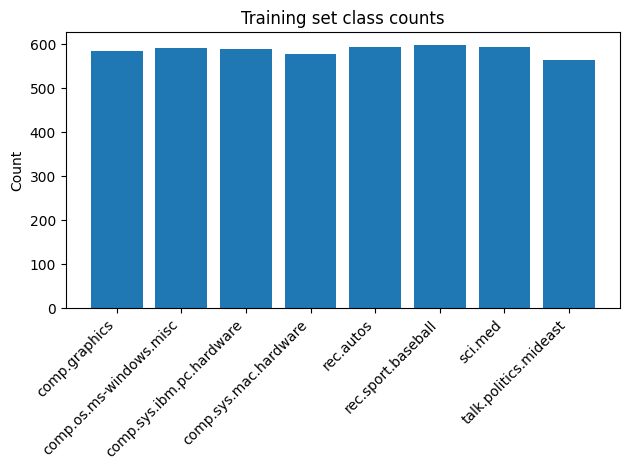

In [ ]:

counts = np.bincount(y_train, minlength=len(target_names))
plt.figure()
plt.bar(range(len(target_names)), counts)
plt.title("Training set class counts")
plt.xticks(range(len(target_names)), target_names, rotation=45, ha='right')
plt.ylabel("Count")
plt.tight_layout()
plt.show()



## 4. Baseline (Dummy Classifier)
Always start with a **sanity-check** baseline.


In [ ]:

baseline = Pipeline([
    ("vect", CountVectorizer(max_features=20000)),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_base))


Baseline accuracy: 0.12704



## 5. Naive Bayes: Intuition (Multinomial & Bernoulli)
We assume features are **conditionally independent** given the class.

For text with counts, **MultinomialNB** models token count likelihoods:
\begin{align}
\hat{y} &= \arg\max_c \ \log P(c) + \sum_{j} x_j \log P(w_j \mid c)
\end{align}

For **binary** features (word present/absent), **BernoulliNB** can be better.
Both use **Laplace/Lidstone smoothing** via the `alpha` hyperparameter.

- Why independence works "well enough" in high dimensions.
- Effect of `alpha`: prevents zero probabilities; too big → over-smoothing.



## 6. MultinomialNB with Bag-of-Words


In [ ]:

bow_nb = Pipeline([
    ("vect", CountVectorizer(max_features=40000, ngram_range=(1,1))),
    ("clf", MultinomialNB(alpha=1.0))
])
bow_nb.fit(X_train, y_train)
y_pred_bow = bow_nb.predict(X_test)

print("Bag-of-Words + MultinomialNB")
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print()
print(classification_report(y_test, y_pred_bow, target_names=target_names))


Bag-of-Words + MultinomialNB
Accuracy: 0.71456

                          precision    recall  f1-score   support

           comp.graphics       0.61      0.80      0.69       389
 comp.os.ms-windows.misc       0.67      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.55      0.80      0.65       392
   comp.sys.mac.hardware       0.73      0.65      0.69       385
               rec.autos       0.87      0.84      0.85       396
      rec.sport.baseball       0.78      0.85      0.82       397
                 sci.med       0.79      0.84      0.81       396
   talk.politics.mideast       0.77      0.94      0.84       376

                accuracy                           0.71      3125
               macro avg       0.72      0.72      0.67      3125
            weighted avg       0.72      0.71      0.67      3125




### Confusion Matrix


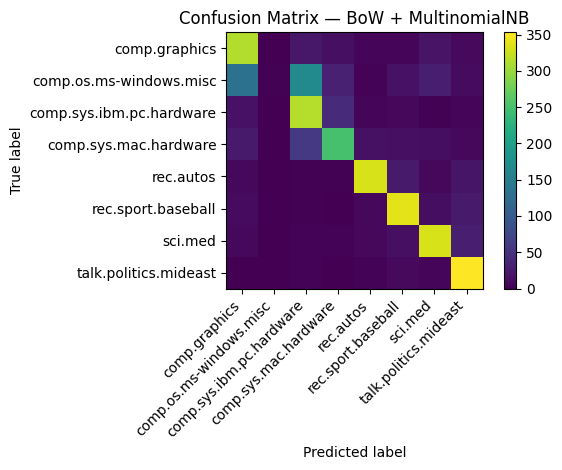

In [ ]:

cm = confusion_matrix(y_test, y_pred_bow)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — BoW + MultinomialNB")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha='right')
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## 7. TF–IDF + MultinomialNB (with `alpha` tuning)


In [ ]:

tfidf_nb = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), sublinear_tf=True)),
    ("clf", MultinomialNB())
])

param_grid = {
    "clf__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(tfidf_nb, param_grid, scoring="accuracy", n_jobs=-1, cv=3, verbose=0)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best score:", grid.best_score_)

best_tfidf_nb = grid.best_estimator_
y_pred_tfidf = best_tfidf_nb.predict(X_test)

print("\nTF–IDF + MultinomialNB (tuned)")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print()
print(classification_report(y_test, y_pred_tfidf, target_names=target_names))


Best params: {'clf__alpha': 0.1}
CV best score: 0.7973145780051151

TF–IDF + MultinomialNB (tuned)
Accuracy: 0.77696

                          precision    recall  f1-score   support

           comp.graphics       0.73      0.79      0.76       389
 comp.os.ms-windows.misc       0.78      0.54      0.64       394
comp.sys.ibm.pc.hardware       0.67      0.75      0.71       392
   comp.sys.mac.hardware       0.78      0.70      0.74       385
               rec.autos       0.80      0.83      0.81       396
      rec.sport.baseball       0.76      0.91      0.83       397
                 sci.med       0.83      0.80      0.82       396
   talk.politics.mideast       0.88      0.90      0.89       376

                accuracy                           0.78      3125
               macro avg       0.78      0.78      0.77      3125
            weighted avg       0.78      0.78      0.77      3125




## 8. BernoulliNB (binary features) + n-grams


In [ ]:

bern_nb = Pipeline([
    ("vect", CountVectorizer(max_features=50000, ngram_range=(1,2), binary=True)),
    ("clf", BernoulliNB(alpha=0.5))
])
bern_nb.fit(X_train, y_train)
y_pred_bern = bern_nb.predict(X_test)

print("BernoulliNB (binary features)")
print("Accuracy:", accuracy_score(y_test, y_pred_bern))
print()
print(classification_report(y_test, y_pred_bern, target_names=target_names))


BernoulliNB (binary features)
Accuracy: 0.5952

                          precision    recall  f1-score   support

           comp.graphics       0.74      0.64      0.69       389
 comp.os.ms-windows.misc       0.91      0.12      0.22       394
comp.sys.ibm.pc.hardware       0.59      0.60      0.60       392
   comp.sys.mac.hardware       0.37      0.84      0.52       385
               rec.autos       0.52      0.82      0.63       396
      rec.sport.baseball       0.78      0.85      0.81       397
                 sci.med       0.78      0.40      0.53       396
   talk.politics.mideast       0.89      0.48      0.62       376

                accuracy                           0.60      3125
               macro avg       0.70      0.60      0.58      3125
            weighted avg       0.70      0.60      0.58      3125




## 9. Feature Introspection — Top Tokens per Class (MultinomialNB)


In [ ]:

# Fit a clean model for inspection
vect = TfidfVectorizer(max_features=30000, ngram_range=(1,2), sublinear_tf=True)
X_train_vec = vect.fit_transform(X_train)

clf = MultinomialNB(alpha=grid.best_params_.get("clf__alpha", 1.0))
clf.fit(X_train_vec, y_train)

feature_names = np.array(vect.get_feature_names_out())

def show_top_tokens_per_class(clf, feature_names, n=15):
    # log probabilities per class
    class_log_prob = clf.feature_log_prob_  # shape [n_classes, n_features]
    for i, cls_name in enumerate(target_names):
        top_idx = np.argsort(class_log_prob[i])[::-1][:n]
        print(f"\nTop tokens for class '{cls_name}':")
        print(", ".join(feature_names[top_idx]))

show_top_tokens_per_class(clf, feature_names, n=15)



Top tokens for class 'comp.graphics':
the, to, for, of, and, is, it, in, graphics, on, you, that, this, can, or

Top tokens for class 'comp.os.ms-windows.misc':
windows, the, to, it, is, and, for, you, of, in, have, file, that, with, this

Top tokens for class 'comp.sys.ibm.pc.hardware':
the, to, it, and, is, of, for, with, have, that, on, you, this, in, drive

Top tokens for class 'comp.sys.mac.hardware':
the, to, is, and, it, mac, of, for, that, with, apple, in, you, on, have

Top tokens for class 'rec.autos':
the, car, to, and, you, of, in, it, that, is, on, for, have, they, cars

Top tokens for class 'rec.sport.baseball':
the, he, and, to, in, of, that, was, is, year, his, for, they, team, at

Top tokens for class 'sci.med':
the, of, to, is, and, it, in, that, you, of the, are, be, this, not, for

Top tokens for class 'talk.politics.mideast':
the, of, to, in, you, and, that, israel, is, not, are, by, it, of the, as



## 10. Error Analysis — Inspect Misclassifications


In [ ]:

def inspect_mistakes(texts, y_true, y_pred, n=5):
    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No misclassifications 🎉")
        return
    sample = np.random.choice(wrong, size=min(n, len(wrong)), replace=False)
    for i, idx in enumerate(sample, 1):
        print(f"--- Mistake {i} ---")
        print(f"True: {target_names[y_true[idx]]} | Pred: {target_names[y_pred[idx]]}")
        print(textwrap.fill(texts[idx].strip().replace('\n',' '), width=100))
        print()

print("Mistakes for best TF–IDF + MultinomialNB:")
inspect_mistakes(X_test, y_test, y_pred_tfidf, n=5)


Mistakes for best TF–IDF + MultinomialNB:
--- Mistake 1 ---
True: comp.os.ms-windows.misc | Pred: comp.sys.ibm.pc.hardware
I've got an old Super VGA card manufactured by SAMPO of Taiwan and I'm looking for a Windows 3.1
Driver for it.  It's based on the Cirrus Logic CL-GD510A-32PC-B chip.  I've contacted the suppliers
here in New Zealand and they say that only Windows 2 divers were ever written by the manufacturer.
So if there's a V3.1 driver out for this chip set I'd like to know -  preferably by e-mail at
rjwjames@waikato.ac.nz                       Thanks is advance

--- Mistake 2 ---
True: rec.autos | Pred: comp.graphics
I think you mean ARPA; AARP is the American Association of Retired Persons, and I seriously doubt
that they'd want young whippersnappers building anything on their backbones, what with de-
calcification and all :-)   The general convention is that if it doesn't have a country tag on it,
it's a US site. That includes:   .com    commercial      .edu    educational   


## 11. Practical Tips & Next Steps
- Try **character n-grams** for noisy text.
- Add **stop-word removal** and **min_df**/**max_df** filtering.
- Use **class_weighting** or **balanced sampling** if classes are skewed.
- For production, wrap your best pipeline with `.predict_proba` thresholds and **calibration** if needed.
- Compare against **linear SVM** or **logistic regression** as stronger baselines.



## 12. 🎙️ Conclusion
- *“Text classification turns documents into vectors, then vectors into decisions.”*
- *“Naive Bayes assumes words are conditionally independent — a bold simplification that works shockingly well.”*
- *“Alpha is smoothing: small alpha trusts the data, large alpha smooths aggressively.”*
- *“Always start with a dumb baseline — then prove your model is smarter.”*
- *“Peek inside the model: which words scream a particular class?”*
